In [1]:
'''

#Enable GPU for this Exercise.

'''



'\n\n#Enable GPU for this Exercise.\n\n'

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import numpy as np
import os
import time

from ray import train, tune

# This package is helpful to apply noise to our images
import skimage

#If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


transformations = transforms.Compose([transforms.ToTensor()])

'''
Import Mnist
'''

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transformations)

mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transformations)

'''
Normalize each input from [0.0,1.0] range
'''
x_train = mnist_train.data.float() / 255.
x_test = mnist_test.data.float() / 255.

'''
Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)


In [3]:
# create your training sets (X_train_GN) and (X_train_SP)

# Add salt and pepper noise to the training set
X_train_SP = skimage.util.random_noise(x_train, mode='s&p', clip=True, amount=0.1)
X_test_SP = skimage.util.random_noise(x_test, mode='s&p', clip=True, amount=0.1)

# Add Gaussian Noise to the training set
X_train_GN = skimage.util.random_noise(x_train, mode='gaussian', clip=True)
X_test_GN = skimage.util.random_noise(x_test, mode='gaussian', clip=True)



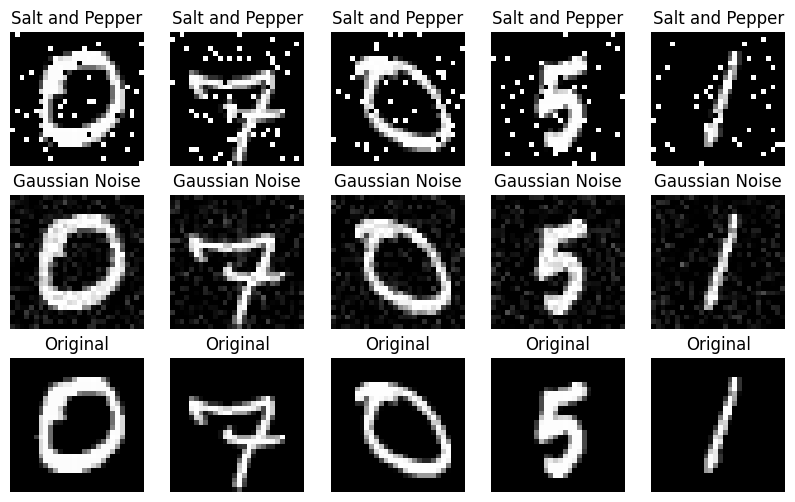

In [4]:
def plot_first_k(noised, original, k=5, labels=['Noised', 'Original'], noised2=None):
    rows = 2 if noised2 is None else 3
    row_original = 1 if noised2 is None else 2
    fig, ax = plt.subplots(rows, k, figsize=(2*k, 2*rows))
    for i, im in enumerate(np.random.choice(len(noised), k)):
        ax[0, i].imshow(noised[im].reshape(28, 28), cmap='gray')
        ax[0, i].set_title(labels[0])
        ax[0, i].axis('off')

        ax[row_original, i].imshow(original[im].reshape(28, 28), cmap='gray')
        ax[row_original, i].set_title(labels[row_original])
        ax[row_original, i].axis('off')
        if noised2 is not None:
            ax[1, i].imshow(noised2[im].reshape(28, 28), cmap='gray')
            ax[1, i].set_title(labels[1])
            ax[1, i].axis('off')

    plt.show()

plot_first_k(X_train_SP, x_train, labels=['Salt and Pepper', 'Gaussian Noise', 'Original'], noised2=X_train_GN)

In [5]:
'''
Create the architecture 

'''

class Autoencoder(nn.Module):
    def __init__(self, in_channels=1, size=(28, 28), channels = [16, 8]):
        super(Autoencoder, self).__init__()

        # Calculating output size from convolutions
        self.H_in = size[0]
        self.W_in = size[1]
        self.channel_1 = channels[0]
        self.channel_2 = channels[1]
        padding = 0
        dilation = 1
        stride_conv = 1
        kernel_conv = 5
        stride_pool = 2
        kernel_pool = 2

        self.H_conv_1 = int((self.H_in + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)
        self.W_conv_1 = int((self.W_in + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)

        self.H_pool_1 = int((self.H_conv_1 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)
        self.W_pool_1 = int((self.W_conv_1 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)

        self.H_conv_2 = int((self.H_pool_1 + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)
        self.W_conv_2 = int((self.W_pool_1 + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)

        self.H_pool_2 = int((self.H_conv_2 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)
        self.W_pool_2 = int((self.W_conv_2 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)

        final_size = int(self.H_pool_2*self.W_pool_2*self.channel_2)


        ## Encoder
        self.encoder_relu = nn.ReLU()
        self.encoder_sig = nn.Sigmoid()

        self.encoder_conv1 = nn.Conv2d(in_channels, channels[0], kernel_size=(5, 5), bias=False)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True)
        self.encoder_conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=(5, 5), bias=False)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True)
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(final_size, 256),
            nn.Sigmoid(),
            nn.Linear(256, 50),
            nn.Sigmoid(),
            nn.Linear(50, final_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (channels[1], int(self.H_pool_2), int(self.W_pool_2)))
        )
        

        ## Decoder
        # First Transposed Convolutional Layer
        self.decode_unpool = nn.MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2))
        self.decode_unconv = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(5, 5), bias=False)
        self.relu = nn.ReLU()
        # Second Transposed Convolutional Layer
        self.decode_unconv2 = nn.ConvTranspose2d(channels[0], in_channels, kernel_size=(5, 5), bias=False)


    def forward(self, x):
        # Encoder Pass
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        x = self.encoder_relu(x)
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)
        x = self.encoder_relu(x)
        x = self.linear(x)
        x = self.decode_unpool(x, indices2, output_size=(x.shape[0], self.channel_2, self.H_conv_2, self.W_conv_2))
        x = self.decode_unconv(x)
        x = self.relu(x)
        x = self.decode_unpool(x, indices1, output_size=(x.shape[0], self.channel_1, self.H_conv_1, self.W_conv_1))
        x = self.decode_unconv2(x)
        x = self.relu(x)

        return x

In [18]:
'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''
def train_single(model, dataloader_train, dataloader_valid, epochs, criterion, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for epoch in range(epochs):
        train_losses = 0
        start_time = time.time()
        model.train()
        for data in dataloader_train:
            img, target = data
            img, target = img.to(device), target.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, target)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses += output.size(0)*loss.item()
            #print(output.size(0), loss.item())
        
        valid_losses = 0
        with torch.no_grad():
            model.eval()
            for data in dataloader_valid:
                img, target = data
                img, target = img.to(device), target.to(device)
                # ===================forward=====================
                output = model(img)
                loss = criterion(output, target)
                valid_losses += output.size(0)*loss.item()

        # ===================log========================
        mean_train_loss = train_losses/len(dataloader_train.dataset)
        mean_valid_loss = valid_losses/len(dataloader_valid.dataset)
        print('epoch [{:3d}/{:3d}], Train Loss:{:.4f} | Validation Loss {:.4f} | Time: {:.4f}'.format(epoch + 1, epochs, mean_train_loss, mean_valid_loss, time.time() - start_time))

    return (mean_train_loss, mean_valid_loss)

data_dir = os.path.abspath("./data")

def load_data():
    print('Loading data from: ', data_dir)
    trainset = datasets.MNIST(
                root=data_dir, train=True, download=True, transform=transformations)
    print('Data loaded.')
    return trainset




In [ ]:
# Finding good hyper parameters for the model
def train_auto(config, data_dir=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_data = load_data()
    x_train = (train_data.data.float() / 255.).reshape(-1, 1, 28, 28)
    x_train_sp = skimage.util.random_noise(x_train, mode='s&p', clip=True, amount=0.1)

    sp_dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train_sp)[:30_000], x_train[:30_000])
    sp_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(x_train_sp)[30_000:], x_train[30_000:])

    sp_dataloader_train = torch.utils.data.DataLoader(sp_dataset_train, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
    sp_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

    model = Autoencoder(channels=config['channels']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    train_valid_loss = train_single(model, sp_dataloader_train, sp_dataloader_valid, 50, criterion, optimizer)
    train.report({'train_loss': train_valid_loss[0], 'valid_loss': train_valid_loss[1]})

search_space = {
    "lr": tune.grid_search([0.001, 0.0001]),
    'channels': tune.grid_search([[16, 8], [32, 16], [64, 32]])
}

trainable_with_resource = tune.with_resources(train_auto, {'cpu': 10, 'gpu': 1})

tuner = tune.Tuner(
    trainable_with_resource,
    param_space=search_space
)

results = tuner.fit()
print(results)

In [21]:
# define the netowrk to be train with the salt and peper corrupted images
# train the network
AutoNN_SP = Autoencoder(channels=[64, 32]).to(device)

sp_dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train_SP), x_train)
sp_dataloader_train = torch.utils.data.DataLoader(sp_dataset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)


sp_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(X_test_SP)[:5_000], x_test[:5_000])
sp_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(AutoNN_SP.parameters(), lr=0.001)

train_valid_loss = train_single(AutoNN_SP, sp_dataloader_train, sp_dataloader_valid, 40, criterion, optimizer)




epoch [  1/ 40], Train Loss:0.0164 | Validation Loss 0.0091 | Time: 2.0053
epoch [  2/ 40], Train Loss:0.0083 | Validation Loss 0.0074 | Time: 2.0174
epoch [  3/ 40], Train Loss:0.0072 | Validation Loss 0.0068 | Time: 2.0329
epoch [  4/ 40], Train Loss:0.0067 | Validation Loss 0.0064 | Time: 2.0302
epoch [  5/ 40], Train Loss:0.0063 | Validation Loss 0.0061 | Time: 2.0264
epoch [  6/ 40], Train Loss:0.0061 | Validation Loss 0.0059 | Time: 2.0366
epoch [  7/ 40], Train Loss:0.0059 | Validation Loss 0.0057 | Time: 2.0370
epoch [  8/ 40], Train Loss:0.0057 | Validation Loss 0.0056 | Time: 2.0333
epoch [  9/ 40], Train Loss:0.0056 | Validation Loss 0.0054 | Time: 2.0075
epoch [ 10/ 40], Train Loss:0.0054 | Validation Loss 0.0053 | Time: 2.0076
epoch [ 11/ 40], Train Loss:0.0053 | Validation Loss 0.0052 | Time: 2.0406
epoch [ 12/ 40], Train Loss:0.0052 | Validation Loss 0.0051 | Time: 2.0326
epoch [ 13/ 40], Train Loss:0.0052 | Validation Loss 0.0051 | Time: 2.0301
epoch [ 14/ 40], Train Lo

In [22]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 
AutoNN_GN = Autoencoder(channels=[64,32]).to(device)

gn_dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train_GN), x_train)
gn_dataloader_train = torch.utils.data.DataLoader(gn_dataset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

gn_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(X_test_GN)[:5_000], x_train[:5_000])
gn_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(AutoNN_GN.parameters(), lr=0.001)

train_valid_loss = train_single(AutoNN_GN, sp_dataloader_train, sp_dataloader_valid, 40, criterion, optimizer)


epoch [  1/ 40], Train Loss:0.0170 | Validation Loss 0.0088 | Time: 2.0473
epoch [  2/ 40], Train Loss:0.0081 | Validation Loss 0.0073 | Time: 2.0615
epoch [  3/ 40], Train Loss:0.0071 | Validation Loss 0.0067 | Time: 2.0333
epoch [  4/ 40], Train Loss:0.0066 | Validation Loss 0.0062 | Time: 2.0284
epoch [  5/ 40], Train Loss:0.0062 | Validation Loss 0.0060 | Time: 2.0331
epoch [  6/ 40], Train Loss:0.0060 | Validation Loss 0.0060 | Time: 2.0477
epoch [  7/ 40], Train Loss:0.0058 | Validation Loss 0.0057 | Time: 2.0528
epoch [  8/ 40], Train Loss:0.0056 | Validation Loss 0.0054 | Time: 2.0480
epoch [  9/ 40], Train Loss:0.0055 | Validation Loss 0.0054 | Time: 2.0487
epoch [ 10/ 40], Train Loss:0.0054 | Validation Loss 0.0053 | Time: 2.0537
epoch [ 11/ 40], Train Loss:0.0052 | Validation Loss 0.0051 | Time: 2.0397
epoch [ 12/ 40], Train Loss:0.0051 | Validation Loss 0.0051 | Time: 2.0379
epoch [ 13/ 40], Train Loss:0.0050 | Validation Loss 0.0049 | Time: 2.0317
epoch [ 14/ 40], Train Lo

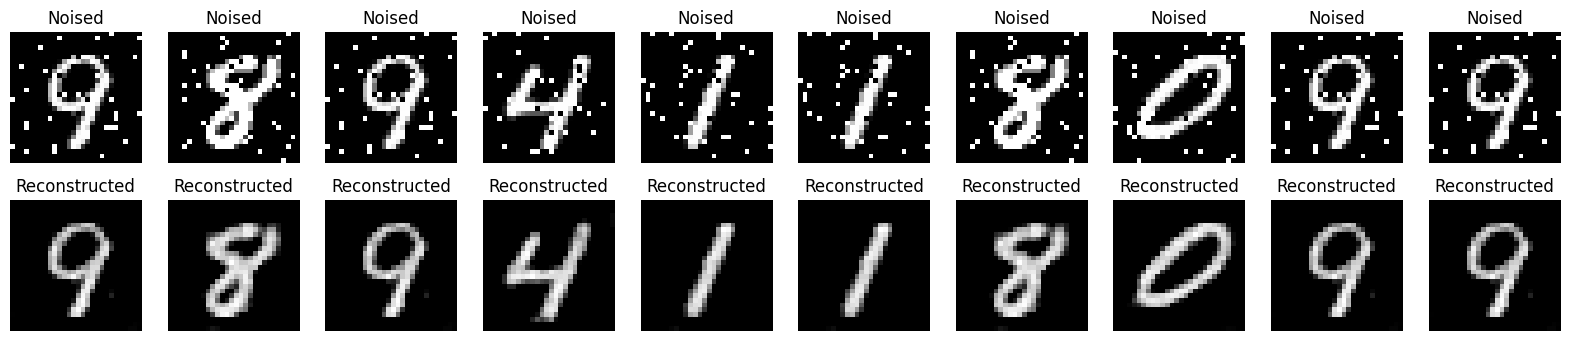

Salt and Pepper Test Loss: 0.0040


In [25]:
# corrupt test images with Salt and peper, pass them through AutoNN_SP 
# plot the results 
AutoNN_SP.eval()
output = AutoNN_SP(torch.tensor(X_test_SP[5_000:5_010]).to(device))
output = output.detach().cpu().numpy()

plot_first_k(X_test_SP[5_000:5_010], output, k=10, labels=['Noised', 'Reconstructed'])
print('Salt and Pepper Test Loss: {:.4f}'.format(criterion(x_test[5_000:5_010].to(device), torch.tensor(output).to(device)).item()))


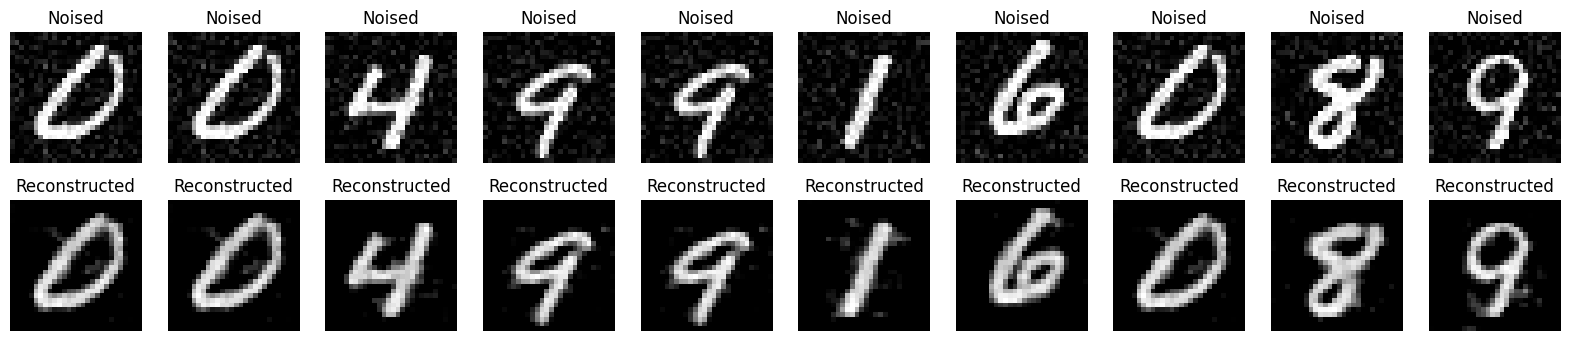

Gaussian Noise Test Loss: 0.0064


In [26]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 
AutoNN_GN.eval()
output = AutoNN_GN(torch.tensor(X_test_GN[5_000:5_010]).to(torch.float).to(device))
output = output.detach().cpu().numpy()

plot_first_k(X_test_GN[5_000:5_010], output, k=10, labels=['Noised', 'Reconstructed'])
print('Gaussian Noise Test Loss: {:.4f}'.format(criterion(x_test[5_000:5_010].to(device), torch.tensor(output).to(device)).item()))
